In [294]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio 
import imutils 

In [309]:
trainImg = imageio.imread('C:/Users/Gautam/Desktop/Aero2Aastro/img1.JPG')
trainImg_gray = cv2.cvtColor(trainImg,cv2.COLOR_RGB2GRAY)

In [311]:
trainImg.shape

(709, 816, 3)

In [312]:
Img=imageio.imread('C:/Users/Gautam/Desktop/Aero2Aastro/img2.JPG')

In [313]:
Img = cv2.resize(Img, (816, 709)) 

In [314]:
Img_gray=cv2.cvtColor(Img,cv2.COLOR_RGB2GRAY)

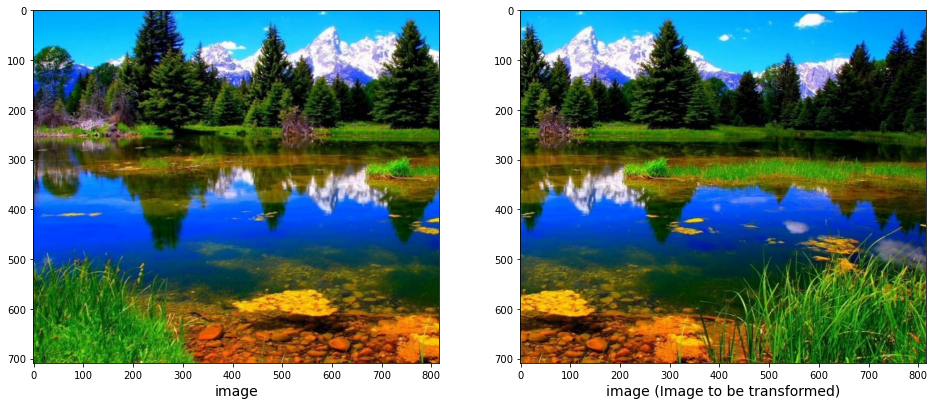

In [315]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(16,9))
ax1.imshow(Img,cmap="gray")
ax1.set_xlabel("image",fontsize=14)
ax2.imshow(trainImg,cmap="gray")
ax2.set_xlabel("image (Image to be transformed)",fontsize=14)
plt.show()

In [316]:
def detectAndDescribe(image,method=None):
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    if method=='sift':
        descriptor=cv2.xfeatures2d.SIFT_create()
    elif method=='surf':
        descriptor=cv2.xfeatures2d.SURF_create(400)
    elif method=='brisk':
        descriptor=cv2.BRISK_create()
    elif method=='orb':
        descriptor=cv2.ORB_create()
    (kps,features)=descriptor.detectAndCompute(image,None)
    
    return(kps,features)

# Keypoint detection

## SIRF and SURF

In [317]:
kpsA,featuresA = detectAndDescribe(trainImg_gray,method=feature_extractor)
kpsB,featuresB = detectAndDescribe(Img_gray,method=feature_extractor)

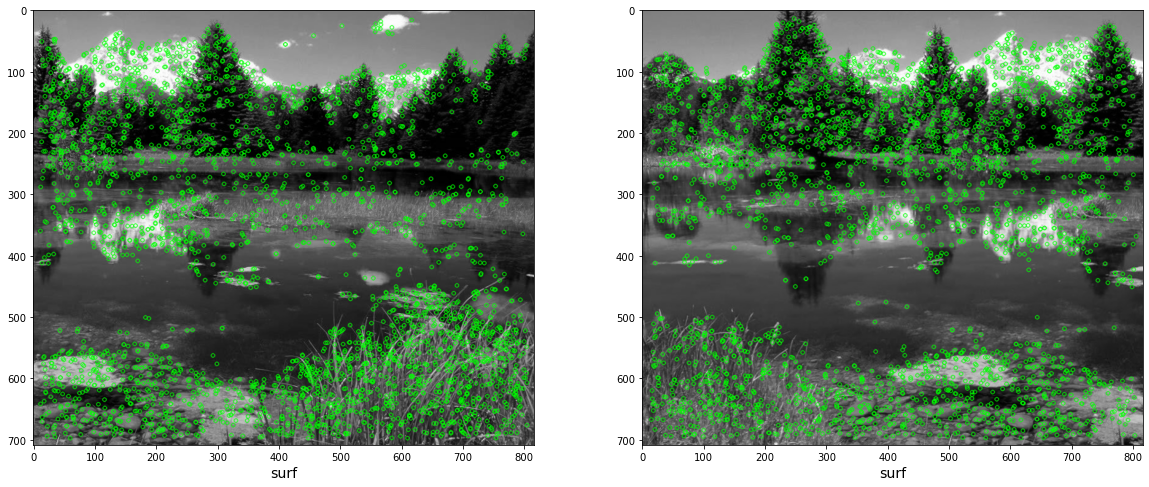

In [318]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,8),constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel(feature_extractor,fontsize=14)
ax2.imshow(cv2.drawKeypoints(Img_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel(feature_extractor,fontsize=14)
plt.show()

In [319]:
def createMatcher(method,crossCheck):
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [320]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
    best_matches = bf.match(featuresA,featuresB)
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    return rawMatches

In [321]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    matches = []
    for m,n in rawMatches:
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

# Feature Matching

## Using BF

In [322]:
feature_extractor = 'surf'

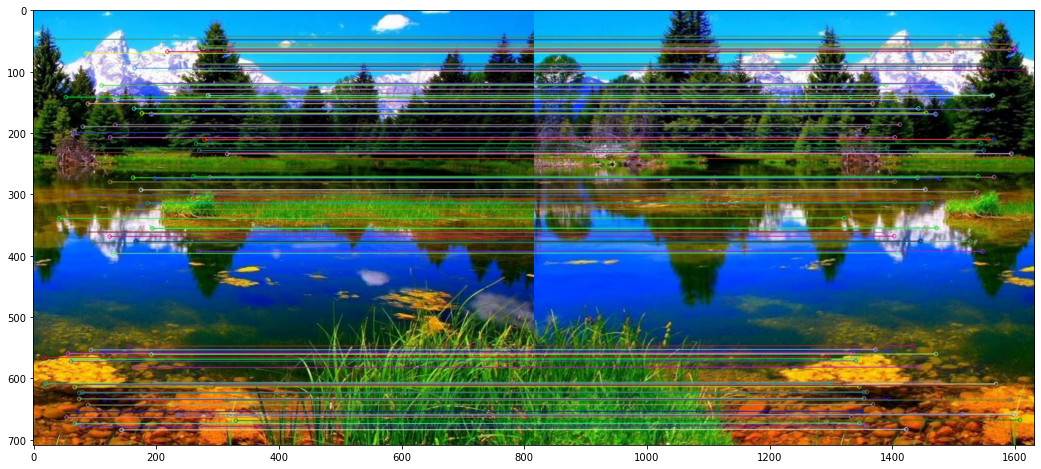

In [323]:
fig = plt.figure(figsize=(20,8))
matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
img3 = cv2.drawMatches(trainImg,kpsA,Img,kpsB,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

### Using KNN

In [324]:
feature_extractor = 'surf'

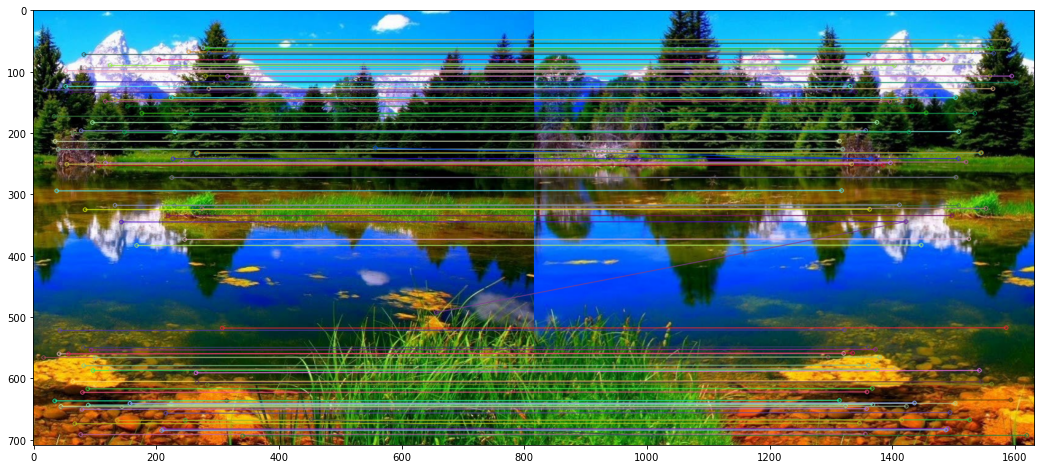

In [325]:
fig = plt.figure(figsize=(20,8))
matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
img3 = cv2.drawMatches(trainImg,kpsA,Img,kpsB,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

## Estimating the Homography

In [326]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
# convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
        reprojThresh)

        return (matches, H, status)
    else:
        return None

In [327]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 9.97172327e-01 -1.27045907e-04  4.61938234e+02]
 [-2.47469934e-04  9.98417741e-01  4.45125767e-02]
 [-2.05730681e-07 -1.21006567e-07  1.00000000e+00]]


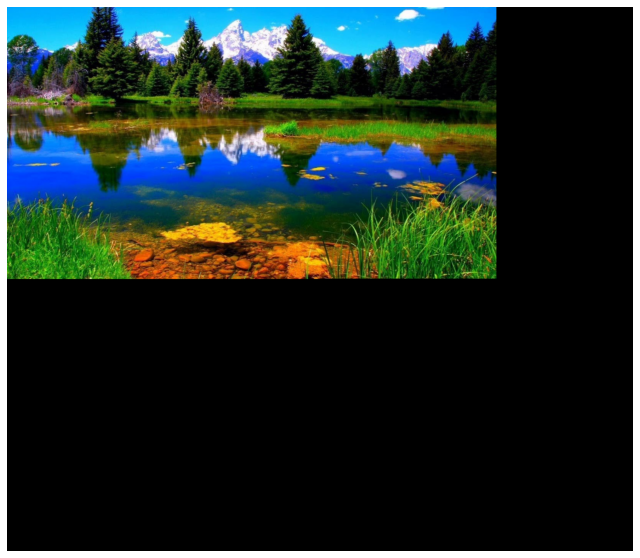

In [328]:

# Apply panorama correction
width = trainImg.shape[1] + Img.shape[1]
height = trainImg.shape[0] + Img.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:Img.shape[0], 0:Img.shape[1]] = Img

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

## Image stiching

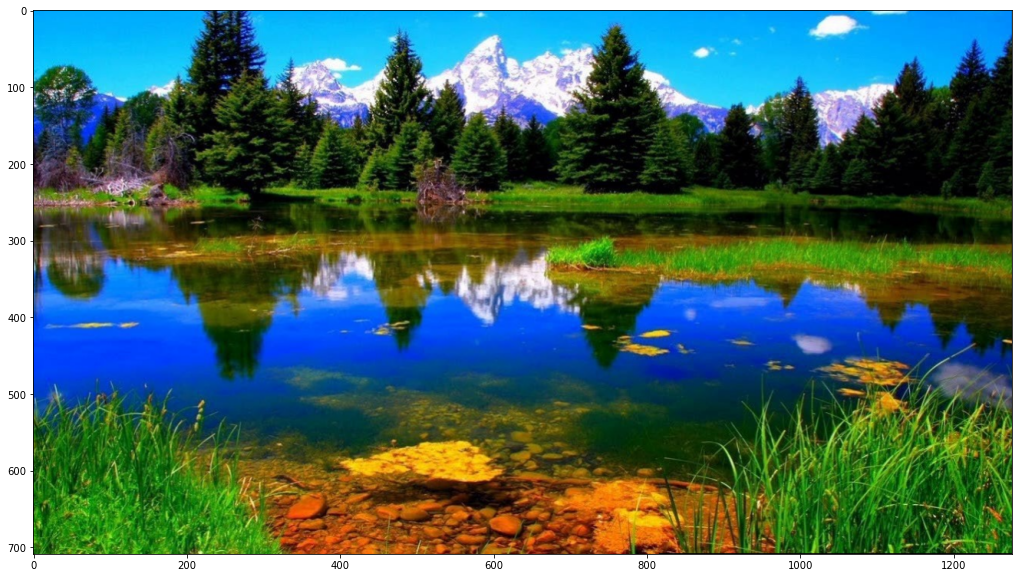

In [329]:
# transform the panorama image to grayscale and threshold it
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)